In [4]:
# import package
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.metrics import matthews_corrcoef, roc_auc_score
from sklearn.cross_validation import cross_val_score, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [5]:
# I'm limited by RAM here and taking the first N rows is likely to be
# a bad idea for the date data since it is ordered.
# Sample the data in a roundabout way:
date_chunks = pd.read_csv("../data/train_date.csv", index_col=0, chunksize=10000, dtype=np.float32)
num_chunks = pd.read_csv("../data/train_numeric.csv", index_col=0,
                         usecols=list(range(969)), chunksize=10000, dtype=np.float32)
X = pd.concat([pd.concat([dchunk, nchunk], axis=1).sample(frac=0.05)
               for dchunk, nchunk in zip(date_chunks, num_chunks)])
y = pd.read_csv("../data/train_numeric.csv", index_col=0, usecols=[0,969], dtype=np.float32).loc[X.index].values.ravel()
X = X.values

In [6]:
clf = XGBClassifier(base_score=0.005)
clf.fit(X, y)

XGBClassifier(base_score=0.005, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

[  63  421  939 1018 1019 1029 1034 1165 1182 1196 1204 1209 1215 1219 1221
 1230 1234 1236 1247 1259 1267 1270 1274 1298 1310 1350 1403 1487 1490 1516
 1519 1541 1543 1549 1550 1837 1844 1862 1879 1883 1884 1887 1888 1889 1890
 1892 1914 1926 1932 1938 1940 1942 1948 1954 1958 1974 1975 1982 1983 1984
 1985 1987 1988 1993 1994 1995 1999 2004 2007 2010 2028 2047 2072 2093]


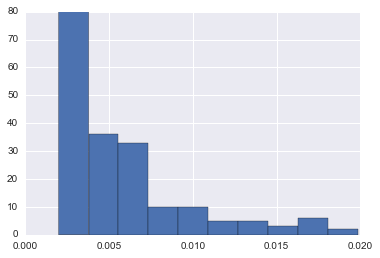

In [7]:
# threshold for a manageable number of features
plt.hist(clf.feature_importances_[clf.feature_importances_>0])
important_indices = np.where(clf.feature_importances_>0.005)[0]
print(important_indices)

In [8]:
# load entire dataset for these features. 
# note where the feature indices are split so we can load the correct ones straight from read_csv
n_date_features = 1156
X = np.concatenate([
    pd.read_csv("../data/train_date.csv", index_col=0, dtype=np.float32,
                usecols=np.concatenate([[0], important_indices[important_indices < n_date_features] + 1])).values,
    pd.read_csv("../data/train_numeric.csv", index_col=0, dtype=np.float32,
                usecols=np.concatenate([[0], important_indices[important_indices >= n_date_features] + 1 - 1156])).values
], axis=1)
y = pd.read_csv("../data/train_numeric.csv", index_col=0, dtype=np.float32, usecols=[0,969]).values.ravel()

In [9]:
clf = XGBClassifier(max_depth=5, base_score=0.005)
cv = StratifiedKFold(y, n_folds=3)
preds = np.ones(y.shape[0])
for i, (train, test) in enumerate(cv):
    preds[test] = clf.fit(X[train], y[train]).predict_proba(X[test])[:,1]
    print("fold {}, ROC AUC: {:.3f}".format(i, roc_auc_score(y[test], preds[test])))
print(roc_auc_score(y, preds))

fold 0, ROC AUC: 0.720
fold 1, ROC AUC: 0.703
fold 2, ROC AUC: 0.697
0.70635585492


0.194081099547


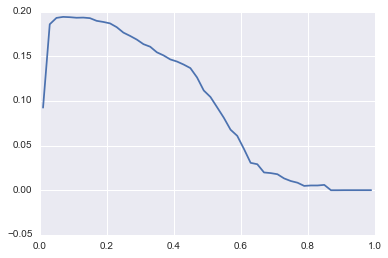

In [10]:
# pick the best threshold out-of-fold
thresholds = np.linspace(0.01, 0.99, 50)
mcc = np.array([matthews_corrcoef(y, preds>thr) for thr in thresholds])
plt.plot(thresholds, mcc)
best_threshold = thresholds[mcc.argmax()]
print(mcc.max())

In [ ]:
# load test data
X = np.concatenate([
    pd.read_csv("../data/test_date.csv", index_col=0, dtype=np.float32,
                usecols=np.concatenate([[0], important_indices[important_indices<1156]+1])).values,
    pd.read_csv("../data/test_numeric.csv", index_col=0, dtype=np.float32,
                usecols=np.concatenate([[0], important_indices[important_indices>=1156] +1 - 1156])).values
], axis=1)

In [ ]:
# generate predictions at the chosen threshold
preds = (clf.predict_proba(X)[:,1] > best_threshold).astype(np.int8)

In [ ]:
# and submit
sub = pd.read_csv("../data/sample_submission.csv", index_col=0)
sub["Response"] = preds
sub.to_csv("submission.csv.gz", compression="gzip")